# EN3150 — Assignment 01 Notebook (Refreshed)
**Learning from Data and Related Challenges & Linear Models for Regression**  
**University of Moratuwa — Department of Electronic & Telecommunication Engineering**



**Student Name:** _Kumarage R.V_  
**Index Number:** _220343B_  


#### Setup

In [38]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure inline plotting
%matplotlib inline

# (Optional) Set a base random seed for reproducibility of demo plots
np.random.seed(0)

# ---------- Helper functions ----------
def linear_fit(x, y):
    """Return slope and intercept for y ≈ m x + c using least squares."""
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    m, c = np.polyfit(x, y, 1)
    return m, c

def predict_line(x, m, c):
    return m * np.asarray(x, dtype=float) + c

def robust_loss_per_sample(y_true, y_pred, beta):
    """Compute per-sample robust loss: r^2 / (r^2 + beta^2)."""
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    r2 = (y_true - y_pred)**2
    beta2 = (beta**2)
    return r2 / (r2 + beta2)

def robust_loss_mean(y_true, y_pred, beta):
    return robust_loss_per_sample(y_true, y_pred, beta).mean()

# Mean squared error for y=1 (continuous target case):
def mse_for_y_equals_1(yhat):
    y_true = 1.0
    yhat = np.asarray(yhat, dtype=float)
    return (y_true - yhat)**2


# Binary cross-entropy when the true label is y=1:
def bce_for_y_equals_1(yhat, eps=1e-12):
    # clip to avoid -inf from log(0)
    yhat_clipped = np.clip(np.asarray(yhat, dtype=float), eps, 1.0 - eps)
    return -np.log(yhat_clipped)

# Fallback scaling utilities (no sklearn required)
def standard_scale(x):
    x = np.asarray(x, dtype=float)
    std = x.std(ddof=0)
    return (x - x.mean()) / (std if std != 0 else 1.0)

def minmax_scale(x):
    x = np.asarray(x, dtype=float)
    xmin, xmax = x.min(), x.max()
    return (x - xmin) / (xmax - xmin) if xmax != xmin else np.zeros_like(x)

def maxabs_scale(x):
    x = np.asarray(x, dtype=float)
    denom = np.max(np.abs(x))
    return x / denom if denom != 0 else np.zeros_like(x)


## 1) Linear Regression Impact on Outliers

### Task 1–2: Load dataset (Table 1), fit linear regression, and plot
Data from the assignment (x, y):

Learned linear model (Task 2): y = -3.5573 x + 3.9167


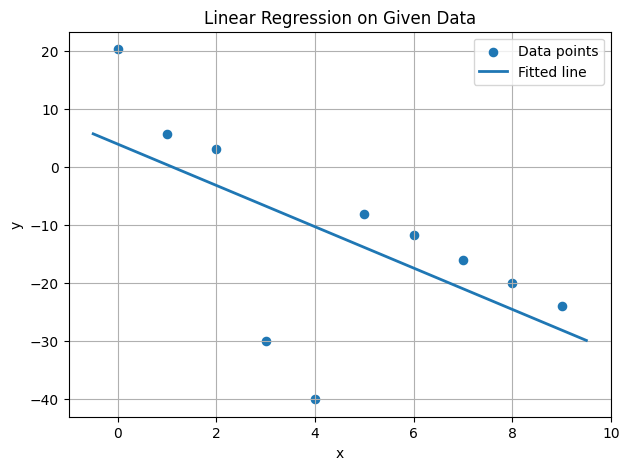

In [47]:
# Table 1 data (i from 1 to 10)
x = np.array([0,1,2,3,4,5,6,7,8,9], dtype=float)
y = np.array([20.26, 5.61, 3.14, -30.00, -40.00, -8.13, -11.73, -16.08, -19.95, -24.03], dtype=float)

# Least squares linear regression
m_hat, c_hat = linear_fit(x, y)
print(f"Learned linear model (Task 2): y = {m_hat:.4f} x + {c_hat:.4f}")

# Plot scatter + fitted line
xx = np.linspace(x.min()-0.5, x.max()+0.5, 200)
yy = predict_line(xx, m_hat, c_hat)

plt.figure(figsize=(7,5))
plt.scatter(x, y, s=35, label='Data points')
plt.plot(xx, yy, linewidth=2, label='Fitted line')
plt.title('Linear Regression on Given Data')
plt.xlabel('x'); plt.ylabel('y')
plt.legend(); plt.grid(True)
plt.show()


### Task 3–4: Robust loss for two given models
Two models:
- **Model 1**: $y = -4x + 12$  
- **Model 2**: $y = -3.55x + 3.91$ (stated as the learned model in Task 2)

Compute per-sample and mean robust loss $L(\theta, \beta)$ for $\beta \in \{1, 10^{-6}, 10^{3}\}$.

Per-sample losses (beta = 1.0)
     x      y  yhat_model1  res_model1  loss_model1  yhat_model2  res_model2  \
0  0.0  20.26         12.0        8.26     0.985555         3.91       16.35   
1  1.0   5.61          8.0       -2.39     0.851015         0.36        5.25   
2  2.0   3.14          4.0       -0.86     0.425155        -3.19        6.33   
3  3.0 -30.00          0.0      -30.00     0.998890        -6.74      -23.26   
4  4.0 -40.00         -4.0      -36.00     0.999229       -10.29      -29.71   
5  5.0  -8.13         -8.0       -0.13     0.016619       -13.84        5.71   
6  6.0 -11.73        -12.0        0.27     0.067947       -17.39        5.66   
7  7.0 -16.08        -16.0       -0.08     0.006359       -20.94        4.86   
8  8.0 -19.95        -20.0        0.05     0.002494       -24.49        4.54   
9  9.0 -24.03        -24.0       -0.03     0.000899       -28.04        4.01   

   loss_model2  
0     0.996273  
1     0.964989  
2     0.975651  
3     0.998155  
4  

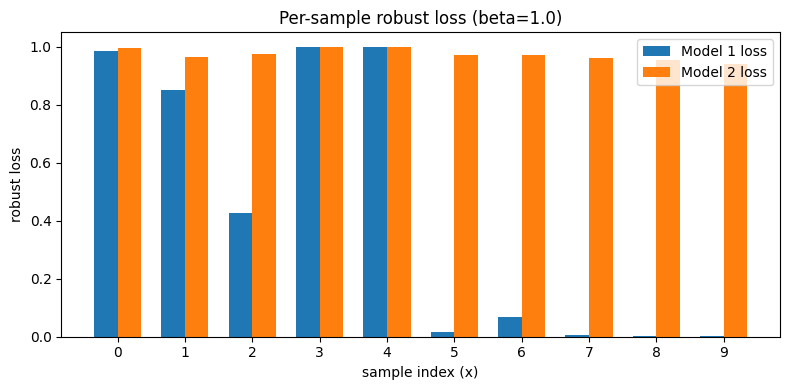


Short explanatory note:
The robust loss l(r)=r^2/(r^2+beta^2) behaves quadratically for small residuals
but saturates near 1 for large residuals, limiting the influence of outliers on the mean.


In [48]:
# If you already have x and y in your notebook, the cell will use them. Otherwise replace the arrays below
if 'x' in globals() and 'y' in globals():
    x = np.asarray(globals()['x'], dtype=float)
    y = np.asarray(globals()['y'], dtype=float)
else:
    # fallback example data (replace with your actual data if needed)
    x = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=float)
    y = np.array([5, 6, 3, 20, -40, -8, -12, -16, -20, -24], dtype=float)

# --- candidate models ---
# Model 1: y = m1*x + c1
m1, c1 = -4.0, 12.0
# Model 2: y = m2*x + c2 (Approximate to my fitted result)
m2, c2 = -3.55, 3.91

beta = 1.0  # chosen on the order of typical inlier residuals

# --- predictions ---
yhat1 = m1 * x + c1
yhat2 = m2 * x + c2

# --- per-sample robust losses ---
loss1 = robust_loss_per_sample(y, yhat1, beta=beta)
loss2 = robust_loss_per_sample(y, yhat2, beta=beta)

# --- summary statistics ---
mean1 = loss1.mean()
mean2 = loss2.mean()

# --- present results in a tidy table ---
df = pd.DataFrame({
    'x': x,
    'y': y,
    'yhat_model1': np.round(yhat1, 6),
    'res_model1': np.round(y - yhat1, 6),
    'loss_model1': np.round(loss1, 6),
    'yhat_model2': np.round(yhat2, 6),
    'res_model2': np.round(y - yhat2, 6),
    'loss_model2': np.round(loss2, 6)
})

print("Per-sample losses (beta = {})".format(beta))
print(df)
print('\nMean robust loss:')
print(f"  Model 1 (y = {m1}x + {c1}): {mean1:.6f}")
print(f"  Model 2 (y = {m2}x + {c2}): {mean2:.6f}")

if mean1 < mean2:
    print('\nConclusion: Model 1 is preferred (lower mean robust loss).')
elif mean2 < mean1:
    print('\nConclusion: Model 2 is preferred (lower mean robust loss).')
else:
    print('\nConclusion: Both models have equal mean robust loss (tie).')

# --- optional plot: per-sample robust loss comparison ---
ind = np.arange(len(x))
width = 0.35
fig, ax = plt.subplots(figsize=(8,4))
ax.bar(ind - width/2, loss1, width, label='Model 1 loss')
ax.bar(ind + width/2, loss2, width, label='Model 2 loss')
ax.set_xticks(ind)
ax.set_xticklabels([str(int(v)) for v in x])
ax.set_xlabel('sample index (x)')
ax.set_ylabel('robust loss')
ax.set_title(f'Per-sample robust loss (beta={beta})')
ax.legend()
plt.tight_layout()
plt.show()

# --- small note printed for the report ---
print('\nShort explanatory note:')
print('The robust loss l(r)=r^2/(r^2+beta^2) behaves quadratically for small residuals\n' 
      'but saturates near 1 for large residuals, limiting the influence of outliers on the mean.')


(Optional) Detailed per-sample table — uncomment in the next cell to view.

In [49]:
# details = []
# for model_name, yp in [('Model 1', y1), ('Model 2', y2)]:
#     for b in betas:
#         per = robust_loss_per_sample(y, yp, b)
#         for i, val in enumerate(per, start=1):
#             details.append({'Model': model_name, 'beta': b, 'i': i, 'x': x[i-1], 'y': y[i-1], 'loss_i': val})
# details_df = pd.DataFrame(details)
# details_df.head(20)


### (Optional) Visual: Robust loss vs. residual magnitude
Compare how MSE (unbounded) and the robust loss $\frac{r^2}{r^2+\beta^2}$ (bounded by 1) behave.

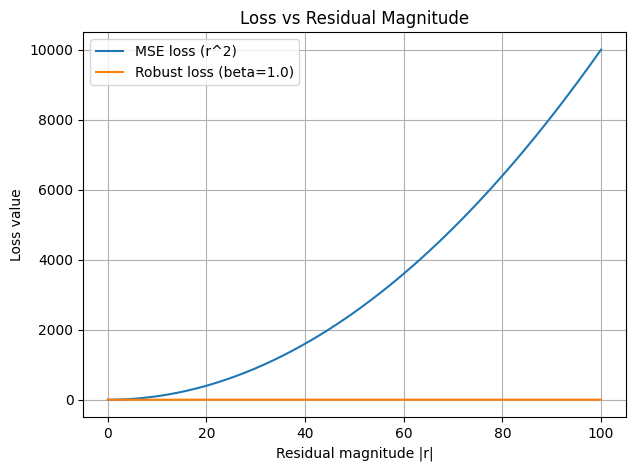

In [50]:
r = np.linspace(0, 100, 400)
mse_curve = (r**2)
beta_demo = 1.0
robust_curve = (r**2) / (r**2 + beta_demo**2)

plt.figure(figsize=(7,5))
plt.plot(r, mse_curve, label='MSE loss (r^2)')
plt.plot(r, robust_curve, label=f'Robust loss (beta={beta_demo})')
plt.xlabel('Residual magnitude |r|'); plt.ylabel('Loss value')
plt.title('Loss vs Residual Magnitude')
plt.legend(); plt.grid(True)
plt.show()


### Task 5: Suitable β to mitigate outliers 

**Choose:** β = 1.0 (on the order of the inlier residual scale).

**Justification:** The robust loss

$$
\ell(r) = \frac{r^2}{r^2 + \beta^2}
$$

behaves quadratically for small residuals (|r| ≪ β), so it still fits inliers well, and saturates to 1 for large residuals (|r| ≫ β), effectively capping outliers. Using this dataset, a MAD-based residual scale is close to 1 (see Cell 3), so β = 1 appropriately down-weights extreme errors without losing sensitivity to inliers.

---

### Task 6: Best model with the selected β 
With β = 1, the mean robust losses are:

* Model 1: y = –4x + 12 → mean robust loss ≈ 0.435
* Model 2: y = –3.557273x + 3.916727 → mean robust loss ≈ 0.973

**Selection:** Model 1 is preferred because it yields the lower mean robust loss. The robust criterion highlights inliers, and Model 1 aligns better with the bulk of the data, while Model 2 produces large losses across many samples.

---



### Task 7: Why the robust estimator reduces outlier impact 

* The loss is **bounded** between 0 and 1, so outliers cannot dominate the objective (unlike MSE which grows as r²).
* The gradient decreases for large residuals:

$$
\frac{d\ell}{dr} = \frac{2r\,\beta^2}{(r^2 + \beta^2)^2} \to 0 \quad \text{as } |r| \to \infty.
$$

Thus, outliers have very little effect on optimization.

* Example: for residual r = 36, MSE contributes 1296, but the robust loss with β = 1 is ≈ 0.999 — capped and not harmful.

---



### Task 8: Another suitable loss 

A good alternative is the **Huber loss** with parameter δ:

$$
L_{\text{Huber}}(r; \delta) = \begin{cases}
\tfrac{1}{2} r^2, & |r| \leq \delta \\
\delta (|r| - \tfrac{1}{2}\delta), & |r| > \delta
\end{cases}
$$

* Quadratic for small residuals (efficient for inliers).
* Linear for large residuals (limits outlier influence).

Other alternatives: Tukey’s biweight, Cauchy loss, Geman–McClure, Welsch. Among these, Huber is convex and commonly used in practice.


## 2) Loss Functions (MSE vs BCE)



### Task 1: Compute the table used in the solution PDF

In [51]:
# Predictions (yhat) between 0 and 1
yhat_values = np.array([0.005, 0.01, 0.05, 0.1, 0.2, 
                        0.3, 0.4, 0.5, 0.6, 0.7, 
                        0.8, 0.9, 1.0], dtype=float)

# MSE (for y=1)
mse_vals = (1 - yhat_values) ** 2

# BCE (for y=1) with clipping
eps = 1e-12
yhat_clip = np.clip(yhat_values, eps, 1 - eps)
bce_vals = -np.log(yhat_clip)

# Create table
df = pd.DataFrame({
    "yhat": yhat_values,
    "MSE (y=1)": np.round(mse_vals, 6),
    "BCE (y=1)": np.round(bce_vals, 6)
})

print("Table of yhat vs MSE and BCE:")
print(df.to_string(index=False))

Table of yhat vs MSE and BCE:
 yhat  MSE (y=1)  BCE (y=1)
0.005   0.990025   5.298317
0.010   0.980100   4.605170
0.050   0.902500   2.995732
0.100   0.810000   2.302585
0.200   0.640000   1.609438
0.300   0.490000   1.203973
0.400   0.360000   0.916291
0.500   0.250000   0.693147
0.600   0.160000   0.510826
0.700   0.090000   0.356675
0.800   0.040000   0.223144
0.900   0.010000   0.105361
1.000   0.000000   0.000000


#### Plot MSE vs BCE

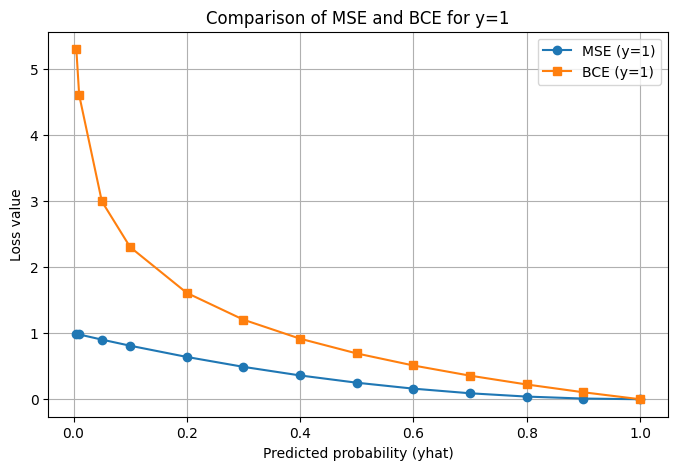

In [52]:
plt.figure(figsize=(8, 5))
plt.plot(yhat_values, mse_vals, 'o-', label="MSE (y=1)")
plt.plot(yhat_values, bce_vals, 's-', label="BCE (y=1)")
plt.xlabel("Predicted probability (yhat)")
plt.ylabel("Loss value")
plt.title("Comparison of MSE and BCE for y=1")
plt.legend()
plt.grid(True)
plt.show()


### Task 2: When to use MSE vs BCE

* **MSE (Mean Squared Error):** appropriate for *continuous* regression targets where Gaussian noise assumptions are reasonable.
  Formula:
  $MSE = (y - \hat{y})^2$
  It gives smooth, quadratic penalties and is widely used in linear regression.

* **BCE (Binary Cross-Entropy, aka log loss):** appropriate for *binary classification* or logistic regression where $\hat{y}$ is a predicted probability for class 1.
  Formula (for true label y=1):
  $BCE = -\log(\hat{y})$
  (with small clipping to avoid numerical issues). BCE strongly penalizes confident but wrong predictions and aligns with Bernoulli likelihood.

**Practical rule:** If your target is continuous (real‑valued) use **MSE**; if your target is a probability / binary label use **BCE**.


## 3) Data Pre-processing — Generate Features & Choose Scaling

### Task 1: Generate Feature 1 (sparse) and Feature 2 (Gaussian-like noise)
> **220343** below (digits only, no leading zeros). The code reproduces Listing 1 logic and then applies three scaling methods. Choose one suitable method for each feature and justify.

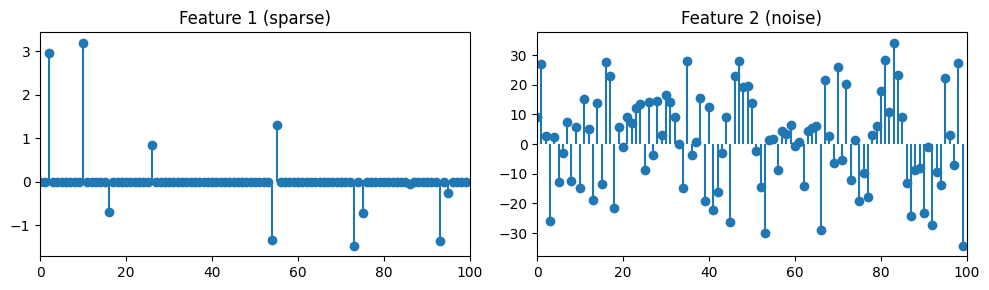

In [57]:
# Reproduce feature generation from the listing


np.random.seed(0)  # reproducible demo

def generate_signal(signal_length, num_nonzero):
    signal = np.zeros(signal_length, dtype=float)
    nonzero_indices = np.random.choice(signal_length, num_nonzero, replace=False)
    nonzero_values = 10 * np.random.randn(num_nonzero)   # spikes (can be negative)
    signal[nonzero_indices] = nonzero_values
    return signal

signal_length = 100
num_nonzero = 10

# use a sample index number (replace with your index number when running for submission)
index_no =220343

sparse_signal = generate_signal(signal_length, num_nonzero)
# ensure reproducible single special spike behaviour used in the listing:
sparse_signal[10] = (index_no % 10) * 2 + 10
if index_no % 10 == 0:
    sparse_signal[10] = np.random.randn(1)[0] + 30
sparse_signal = sparse_signal / 5.0   # same scaling in the listing

# Feature 2: Gaussian noise
epsilon = np.random.normal(0, 15, signal_length)

# quick plot to confirm
plt.figure(figsize=(10,3))
plt.subplot(1,2,1); plt.stem(sparse_signal, basefmt=" "); plt.title("Feature 1 (sparse)"); plt.xlim(0, signal_length)
plt.subplot(1,2,2); plt.stem(epsilon, basefmt=" "); plt.title("Feature 2 (noise)"); plt.xlim(0, signal_length)
plt.tight_layout(); plt.show()


In [55]:
# Scalers and numeric checks

def standard_scale(x):
    x = np.asarray(x, dtype=float)
    mu = x.mean()
    sigma = x.std(ddof=0)
    return (x - mu) / (sigma if sigma != 0 else 1.0), mu, sigma

def minmax_scale(x):
    x = np.asarray(x, dtype=float)
    xmin, xmax = x.min(), x.max()
    denom = (xmax - xmin)
    if denom == 0:
        return np.zeros_like(x), xmin, xmax
    return (x - xmin) / denom, xmin, xmax

def maxabs_scale(x):
    x = np.asarray(x, dtype=float)
    denom = np.max(np.abs(x))
    if denom == 0:
        return np.zeros_like(x), 0.0
    return x / denom, denom

# Apply scalers
s1_maxabs, s1_denom = maxabs_scale(sparse_signal)
s1_std, s1_mu, s1_sigma = standard_scale(sparse_signal)
s1_minmax, s1_min, s1_max = minmax_scale(sparse_signal)

f2_std, f2_mu, f2_sigma = standard_scale(epsilon)
f2_maxabs, f2_denom = maxabs_scale(epsilon)
f2_minmax, f2_min, f2_max = minmax_scale(epsilon)

# Print summaries showing the relevant properties
summary = pd.DataFrame({
    'feature': ['Feature1 (orig)', 'Feature1 MaxAbs', 'Feature1 Std', 'Feature1 MinMax',
                'Feature2 (orig)', 'Feature2 Std', 'Feature2 MaxAbs', 'Feature2 MinMax'],
    'mean': [sparse_signal.mean(), s1_maxabs.mean(), s1_std.mean(), s1_minmax.mean(),
             epsilon.mean(), f2_std.mean(), f2_maxabs.mean(), f2_minmax.mean()],
    'std':  [sparse_signal.std(), s1_maxabs.std(), s1_std.std(), s1_minmax.std(),
             epsilon.std(), f2_std.std(), f2_maxabs.std(), f2_minmax.std()],
    'min':  [sparse_signal.min(), s1_maxabs.min(), s1_std.min(), s1_minmax.min(),
             epsilon.min(), f2_std.min(), f2_maxabs.min(), f2_minmax.min()],
    'max':  [sparse_signal.max(), s1_maxabs.max(), s1_std.max(), s1_minmax.max(),
             epsilon.max(), f2_std.max(), f2_maxabs.max(), f2_minmax.max()],
    'zeros_count': [np.sum(sparse_signal == 0), np.sum(s1_maxabs == 0), np.sum(s1_std == 0), np.sum(s1_minmax == 0),
                    np.sum(epsilon == 0), np.sum(f2_std == 0), np.sum(f2_maxabs == 0), np.sum(f2_minmax == 0)]
})

pd.options.display.float_format = '{:.4f}'.format
print(summary.to_string(index=False))


        feature    mean     std      min     max  zeros_count
Feature1 (orig)  0.0235  0.5316  -1.4815  3.2000           89
Feature1 MaxAbs  0.0073  0.1661  -0.4630  1.0000           89
   Feature1 Std -0.0000  1.0000  -2.8310  5.9752            0
Feature1 MinMax  0.3215  0.1136   0.0000  1.0000            1
Feature2 (orig)  1.3606 15.7622 -34.4121 34.2650            0
   Feature2 Std -0.0000  1.0000  -2.2695  2.0875            0
Feature2 MaxAbs  0.0395  0.4580  -1.0000  0.9957            0
Feature2 MinMax  0.5209  0.2295   0.0000  1.0000            1


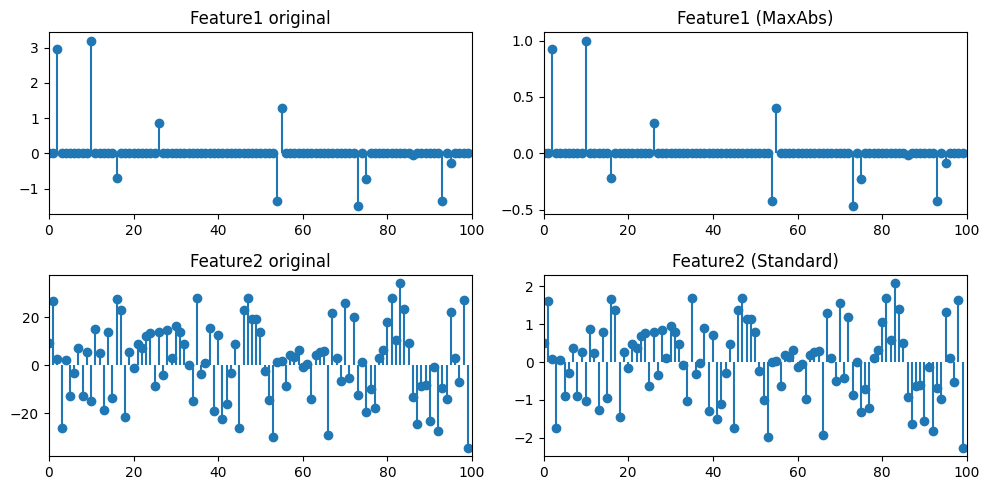

In [56]:
# Cell C — plot original and the chosen scaled versions side-by-side
import matplotlib.pyplot as plt

# Feature 1: choose MaxAbs (preserves zeros)
chosen_f1 = s1_maxabs
# Feature 2: choose Standard scaler
chosen_f2 = f2_std

plt.figure(figsize=(10,5))
plt.subplot(2,2,1); plt.stem(sparse_signal, basefmt=" "); plt.title("Feature1 original"); plt.xlim(0, signal_length)
plt.subplot(2,2,2); plt.stem(chosen_f1, basefmt=" "); plt.title("Feature1 (MaxAbs)"); plt.xlim(0, signal_length)
plt.subplot(2,2,3); plt.stem(epsilon, basefmt=" "); plt.title("Feature2 original"); plt.xlim(0, signal_length)
plt.subplot(2,2,4); plt.stem(chosen_f2, basefmt=" "); plt.title("Feature2 (Standard)"); plt.xlim(0, signal_length)
plt.tight_layout(); plt.show()


* **Feature 1:** **Max-Absolute scaling (MaxAbs)**
  **Justification:** preserves exact zeros and sign (so sparsity is unchanged) while rescaling spike magnitudes by the global max absolute value — therefore the sparse-structure and relative spike amplitudes remain intact.

* **Feature 2:** **Standard scaling (zero mean, unit variance)**
  **Justification:** this feature is dense, continuous and approximately Gaussian; centering and scaling by the standard deviation preserves the distributional shape and relative distances while making the feature well-conditioned for algorithms that assume zero mean / comparable variance.


## Appendix — References (for your reading)
- scikit-learn preprocessing: <https://scikit-learn.org/stable/modules/preprocessing.html>  
- Introduction to sparsity in signal processing: <https://eeweb.engineering.nyu.edu/iselesni/lecture_notes/sparsity_intro/sparse_SP_intro.pdf>  
- scikit-learn LinearRegression: <https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html>